In [1]:
# Sorta like jpeg 2000

# Resources: HW9, 
#            http://faculty.gvsu.edu/aboufade/web/wavelets/student_work/ef/how-works.html,
#            http://www.dmi.unict.it/~battiato/EI_MOBILE0708/JPEG2000%20(Bruna).pdf
#            http://library.msri.org/books/Book46/files/08li.pdf
#            http://www.autex.spb.su/download/wavelet/jpeg2000/jpeg2000_lepley.pdf (quantization)

In [2]:
# Import functions and libraries
%pylab
%matplotlib inline
from __future__ import division
from scipy import misc
# Load project code
from SSTV import *
plt.rcParams['figure.figsize'] = (8, 6) # (16, 16) large plots # (6, 4) for normal size

# Note: use clean8bit(img) when converting from float to unsigned 8-bit

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib

Alex and Diego's project code successfully loaded!



## TODO

In [3]:
    # chroma subsampling
    
    # encoding of zigzagged block
                            
    # transmit encoded blocks
    
    # try DSing images
    
    # investigate quantization effects... (changing step size, image artifacts, etc)

## END TODO

('Max decomposition level:', 6)


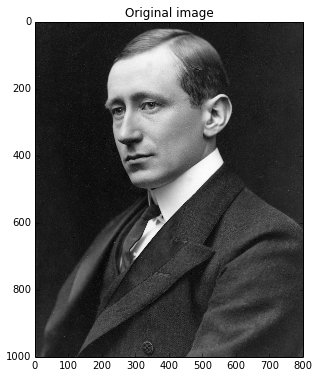

In [4]:
image = misc.imread('imgs/dude.bmp') # load an image: {dude, cal, lake,...}

im = color.rgb2gray(image)

# is the image a wierd shape? 
# i.e., is the num levels smaller than 3?
# im = map2multiple(im, 16)

print('Max decomposition level:', max_decomp_level(im.shape, 'bior4.4'))

original = np.copy(im)
title('Original image')
imshow(original, cmap = 'gray')

In [5]:
num_levels = 3
fraction_coeffs = 0.02
stepsize = 2**num_levels
_delta = 0.6
wavelet = 'bior4.4' # http://wavelets.pybytes.com/wavelet/bior4.4/
dwt2im, orig_bit_depth = compress_bw(im, fraction_coeffs, step_size=stepsize, wvlt=wavelet, level=num_levels)
compressed_img = decompress_bw(dwt2im, im.shape, orig_bit_depth, step_size=stepsize, delta=_delta, wvlt=wavelet, level=num_levels)
# cefs = img2coeffs(dwt2im, num_levels)
compressed_img = clean8bit(compressed_img)
print(abs(dwt2im).max())

117


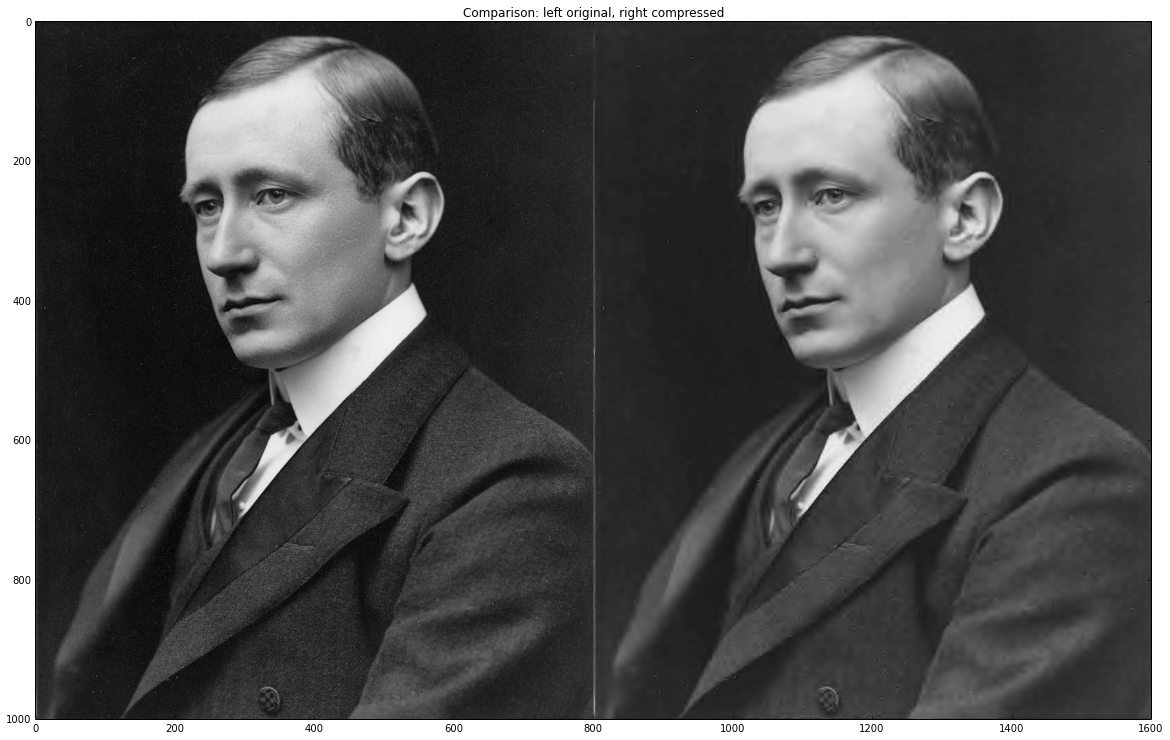

In [6]:
plt.rcParams['figure.figsize'] = (20, 20) # (6, 4) for normal size
compare_imgs(original, compressed_img)
plt.rcParams['figure.figsize'] = (8, 6)

('PSNR:', 111.17860006027705)


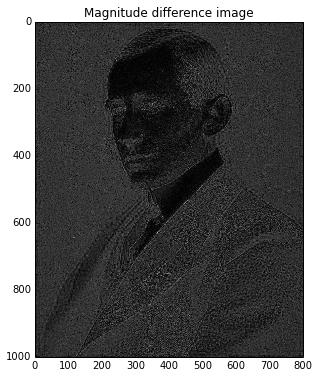

In [7]:
title('Magnitude difference image')
imshow(abs(compressed_img - original), cmap = 'gray')
print('PSNR:',PSNR(compressed_img, im))

In [8]:
cbs = 16
padded = map2multiple(dwt2im, cbs) 
cb = array2code_blocks(padded, cbs);
to_encode = code_blocks2array(cb, im.shape, cbs)
recnxd = map2original(to_encode, im.shape)
print('Decode error:',np.sum(recnxd != dwt2im)/(len(np.ndarray.flatten(recnxd)))*100, '%')

('Decode error:', 0.0, '%')


In [9]:
nz_dwt2im = dwt2im[nonzero(dwt2im)]
nz_original = np.uint8(original)[nonzero(np.uint8(original))]
nz_encode = to_encode[nonzero(to_encode)]

In [10]:
print('Compression ratio using nbytes (numpy):',to_encode.nbytes / np.uint8(original).nbytes)
print('Compression ratio of nonzero indices using nbytes (numpy):',nz_encode.nbytes / nz_original.nbytes)

('Compression ratio using nbytes (numpy):', 1.008)
('Compression ratio of nonzero indices using nbytes (numpy):', 0.02001663883102829)


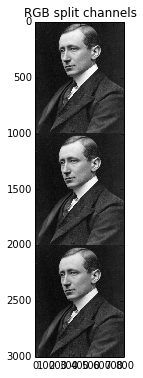

In [11]:
R, G, B = split_img(image)
title('RGB split channels')
imshow(np.vstack([R, G, B]), cmap = 'gray')

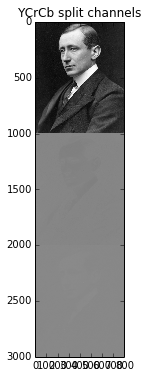

In [12]:
Y, Cr, Cb = split_img(rgb2ycc(image))
title('YCrCb split channels')
imshow(np.vstack([Y, Cr, Cb]), cmap = 'gray')

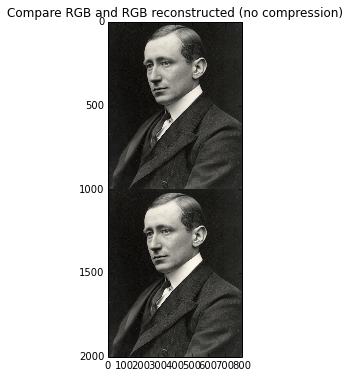

In [13]:
imshow(np.vstack([image, ycc2rgb(join_imgs([Y,Cr,Cb]))]))
title('Compare RGB and RGB reconstructed (no compression)')

In [14]:
# Testing: DWT processing with color images.

('Max decomposition level:', 5)


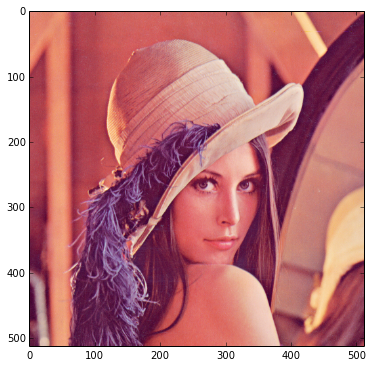

In [15]:
image = misc.imread('imgs/lena.bmp') # load an image: {dude, cal, lake,...}

plt.imshow(image)
# plt.title('Show color image')

original = np.copy(image)
yccimgs = split_img(rgb2ycc(image))

print('Max decomposition level:', max_decomp_level(yccimgs[0].shape, 'bior4.4'))

# is the image a wierd shape? 
# i.e., is the num levels smaller than 3?
# then uncomment below (todo: fix)
#
# map each channel of image to new image with each dim a multiple of 16
#
# mapped = []
# for img in yccimgs:
#     mapped += [map2multiple(img, 16)] 
# yccimgs = mapped
# original = map2multiple(np.copy(image),16)

In [16]:
num_levels = 4
fraction_coeffs = 0.02
stepsize = 2**num_levels # apparently, this makes a big difference. why? (looks like optimal when == 2**num_levels)
_delta = 0.1
wavelet = 'bior4.4' # http://wavelets.pybytes.com/wavelet/bior4.4/

compressed_imgs = []
dwts = []
for im in yccimgs:
    dwt2im, orig_bit_depth = compress_bw(im, fraction_coeffs, step_size=stepsize, wvlt=wavelet, level=num_levels)
    dwts += [dwt2im]
    compressed_img = decompress_bw(dwt2im, im.shape, orig_bit_depth, step_size=stepsize, delta=_delta, wvlt=wavelet, level=num_levels)
    compressed_imgs += [compressed_img]

compressed_img = ycc2rgb(join_imgs(compressed_imgs))
print(np.abs(dwt2im).max())

63


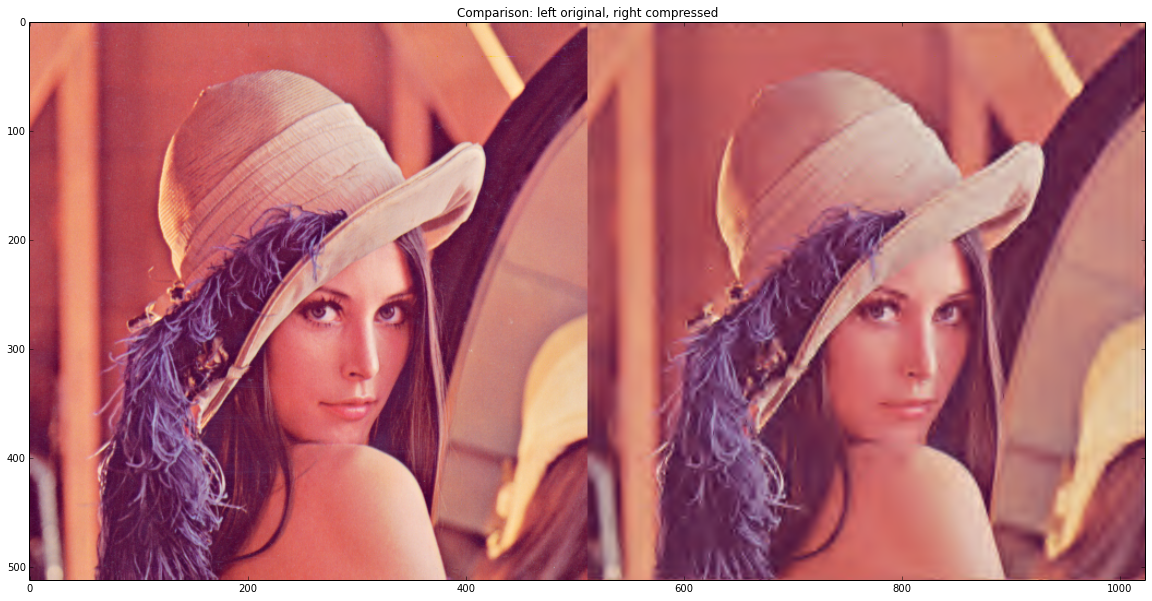

In [17]:
plt.rcParams['figure.figsize'] = (20, 20) # (6, 4) for normal size
compare_imgs(original, compressed_img)
plt.rcParams['figure.figsize'] = (8, 6)

('PSNR:', 115.56363670975014)


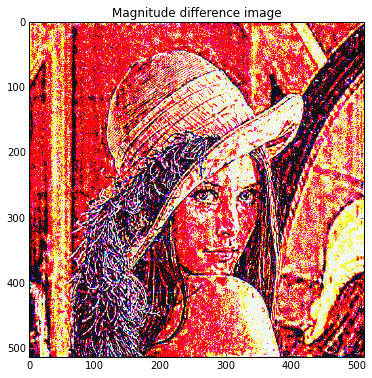

In [18]:
title('Magnitude difference image')
imshow(abs(compressed_img - original))
print('PSNR:', PSNR(compressed_img, image))

In [19]:
blk_size = 16
dwt2im = dwts[0]
mapped = map2multiple(dwt2im, blk_size)
blocks = array2code_blocks(mapped, blk_size)
block_idx = 666

bitstream = block2bitarray(blocks[block_idx])
# Take bitstream and turn it into a transmittable bitstream (encode, NRZ2NRZI, AFSK, etc.)
# Transmit bitstream
# Take received bitstream and turn it into a blockable bitstream (AFSK demod, NRZI2NRZ, decode, etc.)
reblocked = bitarray2block(bitstream)
print('Are they the same?', 0==np.sum(blocks[block_idx] != reblocked))

deblocked = code_blocks2array(blocks, mapped.shape, blk_size)
unmapped = map2original(deblocked, dwt2im.shape)

('Are they the same?', True)
